<a href="https://colab.research.google.com/github/BriouaNorElHouda/py/blob/main/landv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import requests
import os
import io
import cv2
import shutil
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import time

In [ ]:
desired_labels = {
    'AnnualCrop': 0,
    'Forest': 1,
    'HerbaceousVegetation': 2,
    'Highway': 3,
    'Industrial': 4,
    'Pasture': 5,
    'PermanentCrop': 6,
    'Residential': 7,
    'River': 8,
    'SeaLake': 9,
}

In [ ]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/EuroSatDS.zip'

extracted_path = "/content/EuroSatDS"
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extracted_path)

data = []

src_path = os.path.join(extracted_path, "EuroSatDS")
subclass = sorted(os.listdir(src_path))

def create_data():
    for sclass in subclass:
        path = os.path.join(src_path, sclass)
        class_num = subclass.index(sclass)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (64, 64))
            data.append([new_array, class_num])

create_data()

print("Total samples in the dataset:", len(data))

100%|██████████| 2500/2500 [00:00<00:00, 5610.43it/s]

Total samples in the dataset: 22000


In [ ]:

X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class MyDataGenerator(keras.utils.Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.num_samples = len(X)

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, self.num_samples)

        batch_X = self.X[start:end]
        batch_y = self.y[start:end]

        batch_X = np.array(batch_X).reshape(-1,64, 64, 3) / 255.0
        batch_y = np.array(batch_y)

        return batch_X, batch_y

batch_size = 32
train_generator = MyDataGenerator(X_train, y_train, batch_size)
test_generator = MyDataGenerator(X_test, y_test, batch_size)


In [ ]:
NAME="Model1"

model=Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),  activation='relu',  input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

tensorboard= TensorBoard(log_dir="logs\{}".format(NAME))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=10,batch_size=32, validation_data=test_generator,callbacks=[tensorboard])

Epoch 1/10
 15/550 [..............................] - ETA: 2:34 - loss: 2.2728 - accuracy: 0.1021

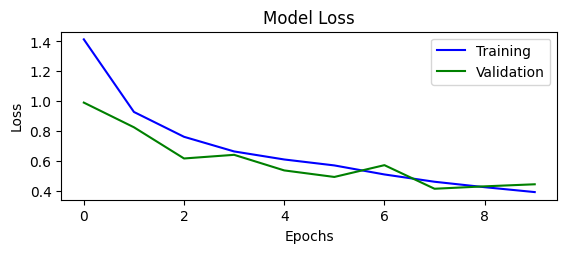

In [ ]:
#Plot Model Loss
plt.subplot(211)
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='green', label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'],loc='upper right')

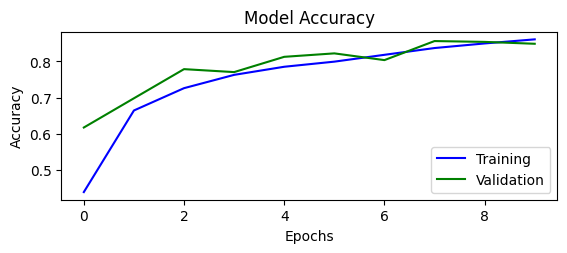

In [ ]:
# Plot Accuracy
plt.subplot(211)
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='green', label='test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'],loc='lower right')

In [ ]:
model.save("land.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 6, 6, 128)        

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def prediction_batch(img_batch):
    img_batch = np.array(img_batch).reshape(-1, 64, 64, 3)
    img_batch = img_batch.astype('uint8') / 255.0

    return np.argmax(model.predict(img_batch), axis=-1)

labels = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]

# Example path to an image
path = "/content/EuroSatDS/EuroSatDS/Industrial/Industrial_1001.jpg"
img = image.load_img(path, target_size=(224, 224, 3))

# Assuming you have already defined `model`

# Single image prediction
print("Prediction for single image:", labels[prediction(img)])

# Using data generator for batch prediction
batch_X = [img]  # Assuming you have a list of images
batch_predictions = prediction_batch(batch_X)
for prediction_idx in batch_predictions:
    print("Prediction for batch image:", labels[prediction_idx])


NameError: name 'prediction' is not defined

In [ ]:

labels = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]


def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64,64,3))
    img_array = image.img_to_array(img)
    img_array = img_array.astype('uint8') / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

path = "/content/drive/MyDrive/Colab Notebooks/TEST/Pasture/Pasture_1.jpg"
img = preprocess_image(path)


predictions = model.predict(img)
predicted_class_index = np.argmax(predictions)


predicted_class = labels[predicted_class_index]

print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 18ms/step
Predicted class: River


In [ ]:
folder_to_delete = '/content/2750'

# Delete the folder and all its contents
shutil.rmtree(folder_to_delete)


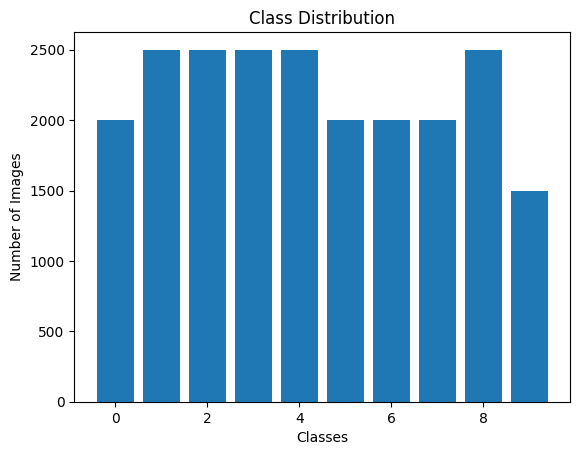

In [ ]:
import matplotlib.pyplot as plt

plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()


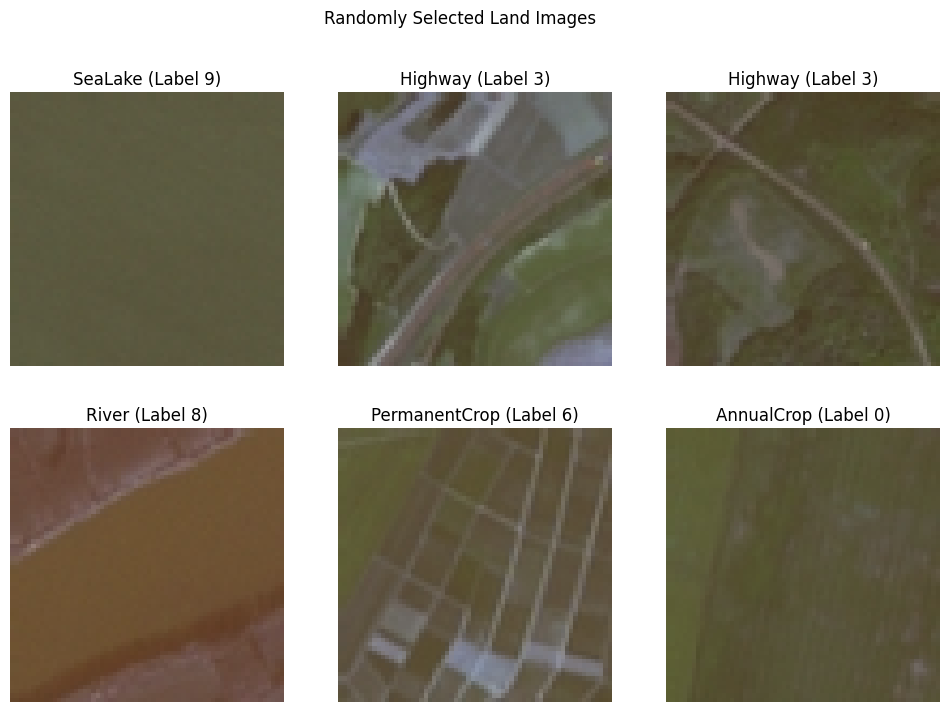

In [ ]:
import random
types = {'AnnualCrop': 0,
         'Forest': 1,
          'HerbaceousVegetation': 2,
          'Highway': 3,
          'Industrial': 4,
          'Pasture': 5,
          'PermanentCrop': 6,
          'Residential': 7,
          'River': 8,
          'SeaLake': 9,
          }

image_files = []
for root, dirs, files in os.walk(src_path):
    for file in files:
        if file.endswith(".jpg"):
            image_files.append((os.path.join(root, file), os.path.basename(root)))

random_images = random.sample(image_files, 6)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Randomly Selected Land Images')

for i, (image_file, land_name) in enumerate(random_images):
    img_array = cv2.imread(image_file, cv2.IMREAD_COLOR)
    new_array = cv2.resize(img_array, (64, 64))

    row_index = i // 3
    col_index = i % 3

    label_number = types[land_name]
    axes[row_index, col_index].imshow(new_array,  cmap=None)
    axes[row_index, col_index].set_title(f'{land_name} (Label {label_number})')
    axes[row_index, col_index].axis('off')

plt.show()

In [ ]:
for sclass in subclass:
    class_num = subclass.index(sclass)
    print(f"Class name: {sclass}, Label index: {class_num}")


Class name: AnnualCrop, Label index: 0
Class name: Forest, Label index: 1
Class name: HerbaceousVegetation, Label index: 2
Class name: Highway, Label index: 3
Class name: Industrial, Label index: 4
Class name: Pasture, Label index: 5
Class name: PermanentCrop, Label index: 6
Class name: Residential, Label index: 7
Class name: River, Label index: 8
Class name: SeaLake, Label index: 9
